In [10]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization,Dropout
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
import keras

In [11]:
file_path = 'data/X_test.npy'
X_test = np.load(file_path)
file_path = 'data/y_test.npy'
y_test = np.load(file_path)
file_path = 'data/X_train.npy'
X_train = np.load(file_path)
file_path = 'data/y_train.npy'
y_train = np.load(file_path)
sizes = np.load('data/sizes.npy')


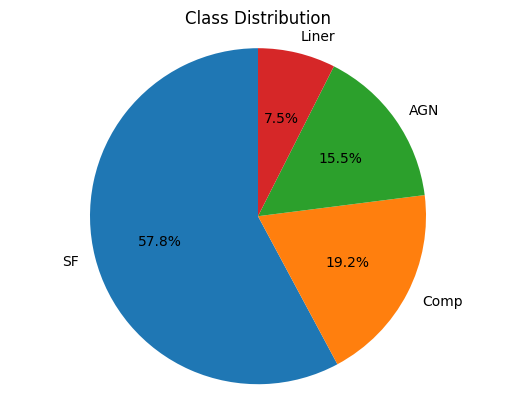

In [12]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['SF', 'Comp', 'AGN', 'Liner']

#colors
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Class Distribution')
plt.show()


In [26]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_split = scaler.transform(X_train_split)

X_val_split = scaler.transform(X_val_split)
X_test = scaler.transform(X_test)

keras.backend.clear_session()
model = Sequential()
model.add(Dense(128,name="fc1", input_shape=(8,), kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(512, name="fc2", kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(512,name="fc3", kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.summary(show_trainable=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ fc1 (Dense)                 │ (None, 128)           │      1,152 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation (Activation)     │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 128)           │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc2 (Dense)                 │ (None, 512)           │     66,048 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_1 (Activation)   │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_1       │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc3 (Dense)                 │ (None, 512)           │    262,656 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_2 (Activation)   │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 4)             │      2,052 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 336,516 (1.28 MB)

 Trainable params: 334,212 (1.27 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_history = model.fit(X_train_split, y_train_split, epochs=20, batch_size=32, verbose=1, shuffle=True, validation_data=(X_val_split, y_val_split))

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7226 - loss: 7.4435 - val_accuracy: 0.7137 - val_loss: 5.0342
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7944 - loss: 4.4316 - val_accuracy: 0.7027 - val_loss: 3.1969
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8213 - loss: 2.7805 - val_accuracy: 0.7967 - val_loss: 2.0325
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8141 - loss: 1.8757 - val_accuracy: 0.8284 - val_loss: 1.4318
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8218 - loss: 1.3377 - val_accuracy: 0.8087 - val_loss: 1.0830
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8145 - loss: 1.0494 - val_accuracy: 0.8175 - val_loss: 0.8978
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8134 - loss: 0.9201 - val_accuracy: 0.7989 - val_loss: 0.8046
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8151 - loss: 0.7781 - val_accur

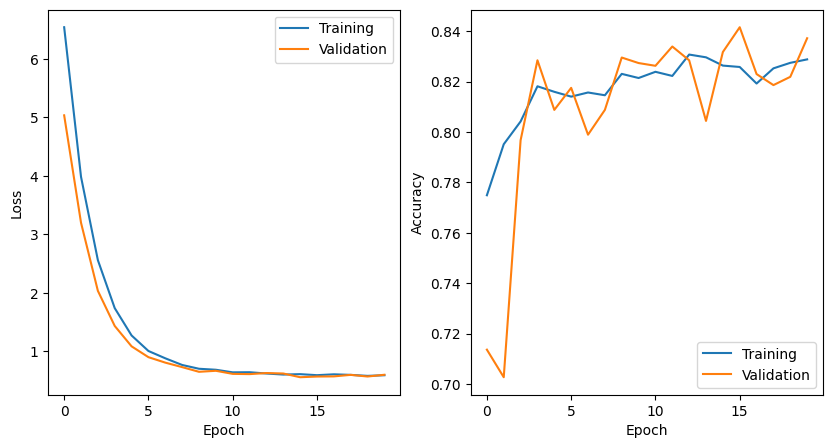

In [28]:
from plotting import plot_model_history

plot_model_history(model_history)

In [29]:
pred = model.predict(X_test,verbose=0)

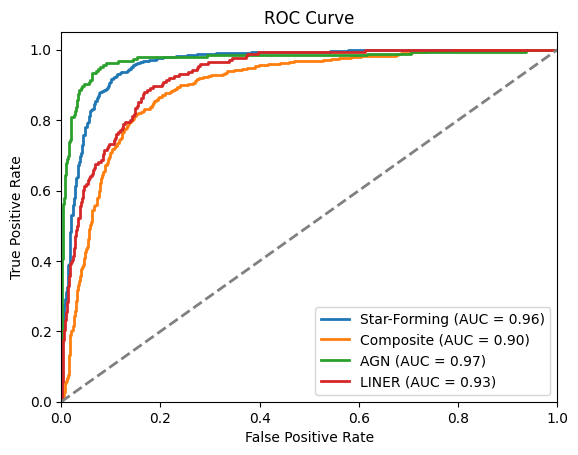

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = pred

fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

classes = ['Star-Forming', 'Composite', 'AGN', 'LINER']

for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(loc='lower right')
plt.show()


# Intermediate Redshift Galaxies (0.32<z<0.8)

We now test our trained model on the intermediate redshift galaxy dataset to see how it performs.

In [ ]:

#open intermediate redshift file

import pickle
import kcorrect
from kcorrect import fitter  # Assuming 'fitter' is still part of the kcorrect module

def preprocess_data(input_file):
    # Read data
    data = Table.read(input_file, header_start=0, data_start=1)

    # More selection based on new magnitudes
    valid_indices = np.where(
        (data['o3'] > 0) & (data['o21'] > 0) & (data['o22'] > 0) & (data['hb'] > 0) &
        (data['ha'] > 0) & (data['s21'] > 0) & (data['s22'] > 0) & (data['sigma_o3'] > 0) &
        (data['sigma_o3_err'] > 0) & (data['VDISP'] > 0) & (data['mag_u'] > 0) &
        (data['flux_g'] > 0) & (data['flux_r'] > 0) & (data['flux_z'] > 0)
    )

    valid_indices = np.where(
        (10 < data['mag_g']) & (data['mag_g'] < 40) &
        (5 < data['mag_r']) & (data['mag_r'] < 40) &
        (5 < data['mag_z']) & (data['mag_z'] < 40)
    )[0]

    if len(valid_indices) == 0:
        raise ValueError("No valid sources found after filtering.")
    
    maggie_u=10**((22.5-data['mag_u'][valid_indices])/2.5)
    maggie_g=10**((22.5-data['mag_g'][valid_indices])/2.5)
    maggie_r=10**((22.5-data['mag_r'][valid_indices])/2.5)
    maggie_i=10**((22.5-data['mag_i'][valid_indices])/2.5)
    maggie_z=10**((22.5-data['mag_z'][valid_indices])/2.5)    

    z_arr=data['z'][valid_indices]

    import kcorrect.kcorrect

    responses = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']
    kc = kcorrect.kcorrect.Kcorrect(responses=responses)
    ivar = np.array([6.216309e+16, 3.454767e+17, 1.827409e+17, 1.080889e+16, 3163927000000000.0])

    for i in range(len(valid_indices)):
        maggies = np.array([maggie_u[i], maggie_g[i], maggie_r[i], maggie_i[i], maggie_z[i]])
        c = kc.fit_coeffs(redshift=data['z'][valid_indices[i]], maggies=maggies, ivar=ivar)
        m = kc.kcorrect(redshift=data['z'][valid_indices[i]], coeffs=c)
        maggie_u[i]=m[0]
        maggie_g[i]=m[1]
        maggie_r[i]=m[2]
        maggie_i[i]=m[3]
        maggie_z[i]=m[4]

    indt=np.where(maggie_u <=0)
    maggie_u[indt]=0.001
    indt=np.where(maggie_g <=0)
    maggie_g[indt]=0.001
    indt=np.where(maggie_r <=0)
    maggie_r[indt]=0.001
    indt=np.where(maggie_i <=0)
    maggie_i[indt]=0.001
    indt=np.where(maggie_z <=0)
    maggie_z[indt]=0.001

    # Convert back to magnitudes
    mags_corrected = 22.5 - 2.5 * np.log10(np.array([maggie_u, maggie_g, maggie_r, maggie_i, maggie_z]).T)

    # Compute features
    O2_index = np.log10((data['o21'][valid_indices] + data['o22'][valid_indices]) / data['hb'][valid_indices])
    O3_index = np.log10(data['o3'][valid_indices] / data['hb'][valid_indices])
    sigma_o3 = np.log10(np.sqrt(data['sigma_o3'][valid_indices] ** 2))
    sigma_star = np.log10(data['VDISP'][valid_indices])
    sigma_star[sigma_star == 0] = 10.0

    u_g, g_r, r_i, i_z = np.diff(mags_corrected, axis=1).T

    for arr in [O3_index, O2_index, sigma_star, sigma_o3, u_g, g_r, r_i, i_z]:
        arr[np.isinf(arr)] = 0
        arr = np.nan_to_num(arr)

    X_test = np.column_stack([O3_index, O2_index, sigma_star, sigma_o3, u_g, g_r, r_i, i_z])

    return X_test


In [38]:
X_test = preprocess_data('data_elg.csv')

mag_g values <= 0: 33
mag_r values <= 0: 33
mag_i values <= 0: 33
mag_z values <= 0: 33
1464


In [ ]:
pred = model.predict(X_test,verbose=0)

